# Generate Approximate Hessians
Like the previous notebook, fit an approximate model and use that to compute the Hessian. Instead of treating the Hessian parameters as separate, we try here to fit a forcefield using the data.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jitterbug.model.dscribe.globald import DScribeGlobalEnergyModel
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from dscribe.descriptors import MBTR
from ase.vibrations import VibrationsData
from ase.db import connect
from pathlib import Path
from tqdm import tqdm
import numpy as np
import warnings
import ase

Configuration

In [2]:
db_path = '../1_explore-sampling-methods/data/along-axes/caffeine_pm7_None_d=5.00e-03-N=2.db'

Derived

In [3]:
run_name, sampling_options = Path(db_path).name[:-3].rsplit("_", 1)
exact_path = Path('../data/exact/') / f'{run_name}-ase.json'
sampling_name = Path(db_path).parent.name
out_name = '_'.join([run_name, sampling_name, sampling_options])

## Read in the Data
Get all computations for the desired calculation and the exact solution

In [4]:
with connect(db_path) as db:
    data = [a.toatoms() for a in db.select('')]
print(f'Loaded {len(data)} structures')

Loaded 5185 structures


Read in the exact Hessian

In [5]:
with open(exact_path) as fp:
    exact_vibs = VibrationsData.read(fp)

In [6]:
exact_hess = exact_vibs.get_hessian_2d()
exact_zpe = exact_vibs.get_zero_point_energy()

## Adjust Hyperparameters
We have a few different hyperparameters to fit, the type of descriptors we use and those of the underlying model.

In [7]:
train_data, test_data = train_test_split(data, test_size=0.5)

Get a baseline score

In [8]:
test_y = np.array([a.get_potential_energy() for a in test_data])
baseline_y = np.abs(test_y - test_y.mean()).mean()
print(f'Baseline score: {baseline_y*1000:.2e} meV/atom')`

Baseline score: 5.48e-01 meV/atom


In [9]:
def test_model(train_data: list[ase.Atoms], test_data: list[ase.Atoms], descriptor: MBTR, model: GridSearchCV) -> float:
    """Get the MAE for a combination of descriptor and model"""
    
    # Compute descriptors and get energies
    train_x = descriptor.create(train_data)
    train_y = np.array([a.get_potential_energy() for a in train_data])
    scale_y, offset_y = train_y.std(), train_y.mean()
    train_y = (train_y - offset_y) / scale_y
    
    # Fit the model
    model.fit(train_x, train_y)
    
    # Run on the test set
    test_x = descriptor.create(test_data)
    pred_y = (model.predict(test_x) * scale_y) + offset_y
    
    # Return the error
    test_y = np.array([a.get_potential_energy() for a in test_data])
    return mean_absolute_error(test_y, pred_y)

We'll use KRR for all the tests

In [10]:
model = Pipeline(
    [('scale', StandardScaler()), 
     ('krr', GridSearchCV(KernelRidge(kernel='rbf', alpha=1e-10), {'gamma': np.logspace(-5, 5, 32)}))]
)

Start off with testing 2D descriptors. We'll want to evaluate the maximum distance of the grid and the number of points

In [11]:
max_dists = np.arange(2, 6.01, 0.25)
n_points = 32
sigma = 0.1
test_score = []
for max_dist in tqdm(max_dists):
    desc = MBTR(
        species=["H", "C", "N", "O"],
        geometry={"function": "distance"},
        grid={"min": 0.5, "max": max_dist, "n": n_points, "sigma": sigma},
        weighting={"function": "exp", "scale": 0.1, "threshold": 1e-3},
        periodic=False,
    )
    test_score.append(test_model(train_data, test_data, desc, model))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [05:18<00:00, 18.73s/it]


In [12]:
max_dist = max_dists[np.argmin(test_score)]
print(f'Selected a maximum distance of {max_dist:.2f} A')

Selected a maximum distance of 5.25 A


In [13]:
n_pointss = [8, 16, 32, 64, 128]
sigma = 0.1
test_score = []
for n_points in tqdm(n_pointss):
    desc = MBTR(
        species=["H", "C", "N", "O"],
        geometry={"function": "distance"},
        grid={"min": 0.5, "max": max_dist, "n": n_points, "sigma": sigma},
        weighting={"function": "exp", "scale": 0.1, "threshold": 1e-3},
        periodic=False,
    )
    test_score.append(test_model(train_data, test_data, desc, model))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:42<00:00, 20.47s/it]


In [14]:
n_points = n_pointss[np.argmin(test_score)]
best_2d_score = min(test_score)
best_2d_desc = MBTR(
    species=["H", "C", "N", "O"],
    geometry={"function": "distance"},
    grid={"min": 0.5, "max": max_dist, "n": n_points, "sigma": sigma},
    weighting={"function": "exp", "scale": 0.1, "threshold": 1e-3},
    periodic=False,
)
print(f'Selected {n_points} grid points. Best 2D score: {best_2d_score*1000:.2e} meV/atom')

Selected 16 grid points. Best 2D score: 1.71e-02 meV/atom


Optimize for 3D. We have a cutoff distance, but it appears in the weighting now.

In [15]:
r_cutoffs = np.arange(2, 12.01, 2.)
n_points = 32
test_score = []
for r_cutoff in tqdm(r_cutoffs):
    desc = MBTR(
        species=["H", "C", "N", "O"],
        geometry={"function": "angle"},
        grid={"min": 0., "max": 180, "n": n_points, "sigma": 180. / n_points / 2.},
        weighting={"function": "smooth_cutoff", "r_cut": r_cutoff, "threshold": 1e-3},
        periodic=False,
    )
    test_score.append(test_model(train_data, test_data, desc, model))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:40<00:00, 36.83s/it]


In [16]:
r_cutoff = r_cutoffs[np.argmin(test_score)]
print(f'Selected a maximum distance of {r_cutoff:.2f} A. Score: {min(test_score)*1000:.2e} meV/atom')

Selected a maximum distance of 6.00 A. Score: 1.02e-02 meV/atom


In [17]:
n_pointss = [8, 16, 32, 64]
test_score = []
for n_points in tqdm(n_pointss):
    desc = MBTR(
        species=["H", "C", "N", "O"],
        geometry={"function": "angle"},
        grid={"min": 0., "max": 180, "n": n_points, "sigma": 180. / n_points / 2.},
        weighting={"function": "smooth_cutoff", "r_cut": r_cutoff, "threshold": 1e-3},
        periodic=False,
    )
    test_score.append(test_model(train_data, test_data, desc, model))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:30<00:00, 37.74s/it]


In [18]:
n_points = n_pointss[np.argmin(test_score)]
best_3d_score = min(test_score)
best_3d_desc = MBTR(
    species=["H", "C", "N", "O"],
    geometry={"function": "angle"},
    grid={"min": 0., "max": 180, "n": n_points, "sigma": 180. / n_points / 2.},
    weighting={"function": "smooth_cutoff", "r_cut": r_cutoff, "threshold": 1e-3},
    periodic=False,
)
print(f'Selected {n_points:} points. Score: {min(test_score)*1000:.2e} meV/atom')

Selected 16 points. Score: 8.66e-03 meV/atom


Pick either the 2D or 3D, as applicable

In [19]:
desc = best_2d_desc if best_2d_score < best_3d_score else best_3d_desc

## Fit a Hessian with All Data
Use the provided energy model

In [20]:
model = DScribeGlobalEnergyModel(
    reference=data[0],
    model=model,
    descriptors=desc,
    num_calculators=2
)

In [21]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    hess_models = model.train(data)

CPU times: user 1h 38min 50s, sys: 2min 31s, total: 1h 41min 22s
Wall time: 9min 7s


Compare the forces estimated at a zero displacement to the true value

In [25]:
actual_forces = data[0].get_forces()

In [26]:
pred_forces = hess_models[0].get_forces(data[0])

In [27]:
print(f'Maximum force: {np.abs(pred_forces).max():.2e} eV/Angstrom')

Maximum force: 3.14e-02 eV/Angstrom


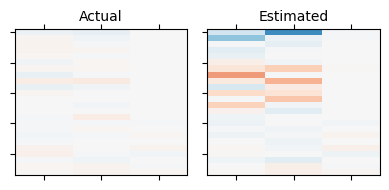

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))

for ax, l, h in zip(axs, ['Actual', 'Estimated'], [actual_forces, pred_forces]):
    ax.matshow(h, vmin=-0.05, vmax=0.05, aspect='auto', cmap='RdBu')

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_title(l, fontsize=10)

fig.tight_layout()

Get the mean Hessian

In [31]:
%%time
approx_hessian = model.mean_hessian(hess_models)

CPU times: user 12min 20s, sys: 26.6 s, total: 12min 46s
Wall time: 4min 15s


Compare to exact answer

In [32]:
exact_hess[:3, :3]

array([[ 1.42193910e+01,  2.19101005e+01, -2.39586674e-04],
       [ 2.19101005e+01,  7.86328494e+01, -3.46912831e-05],
       [-2.39586674e-04, -3.46912831e-05,  2.52655314e+00]])

In [33]:
approx_hessian[:3, :3]

array([[1.73301126e+01, 2.66199439e+01, 1.17359295e-02],
       [2.66199439e+01, 9.95655784e+01, 4.70084143e-02],
       [1.17359295e-02, 4.70084143e-02, 2.30755503e+00]])

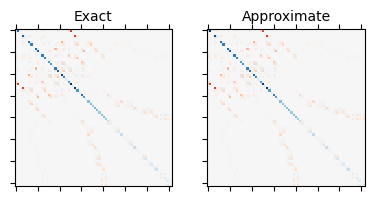

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))

for ax, l, h in zip(axs, ['Exact', 'Approximate'], [exact_hess, approx_hessian]):
    ax.matshow(h, vmin=-100, vmax=100, cmap='RdBu')

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_title(l, fontsize=10)

fig.tight_layout()

Get the zero point energy

In [35]:
approx_vibs = VibrationsData.from_2d(data[0], approx_hessian)

In [36]:
approx_vibs.get_zero_point_energy()

4.804039278125661

In [37]:
exact_zpe

4.746888516975277

The two differ, but I'm not sure how important the difference is.

Save it to disk

In [38]:
out_dir = Path('data/mbtr')
out_dir.mkdir(exist_ok=True, parents=True)
with open(f'data/mbtr/{out_name}.json', 'w') as fp:
    approx_vibs.write(fp)

## Plot as a Function of Data
See what happens as we add more data to the training

In [39]:
steps = np.linspace(5, len(data), 16, dtype=int)
print(f'Plotting at {len(steps)} steps: {", ".join(map(str, steps[:5]))}, ...')

Plotting at 16 steps: 5, 350, 695, 1041, 1386, ...


In [40]:
zpes = []
for count in tqdm(steps):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        hess_model = model.train(data[:count])
    
    approx_hessian = model.mean_hessian(hess_model)
    approx_vibs = VibrationsData.from_2d(data[0], approx_hessian)
    zpes.append(approx_vibs.get_zero_point_energy())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [1:30:46<00:00, 340.43s/it]


Plot it

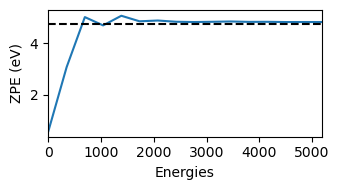

In [41]:
fig, ax = plt.subplots(figsize=(3.5, 2))

ax.plot(steps, zpes)

ax.set_xlim([0, steps.max()])
ax.plot(ax.get_xlim(), [exact_zpe]*2, 'k--')

ax.set_xlabel('Energies')
ax.set_ylabel('ZPE (eV)')

fig.tight_layout()